# Setting and Download

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

######################################
import random

######################################
import os
import zipfile
import glob
#from pathlib import Path

######################################
#from PIL import Image, ImageDraw
import matplotlib.image as mpimg


######################################
#import sklearn


######################################
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

## Download and Unzip dataa

In [73]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O horse-or-human.zip
# -O ouput filename

--2021-03-09 13:45:42--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M   155MB/s    in 0.9s    

2021-03-09 13:45:43 (155 MB/s) - ‘horse-or-human.zip’ saved [149574867/149574867]



In [74]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O validation-horse-or-human.zip

--2021-03-09 13:45:44--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]
Saving to: ‘validation-horse-or-human.zip’

validation-horse-or 100%[===================>]  10.95M  --.-KB/s    in 0.07s   

2021-03-09 13:45:44 (148 MB/s) - ‘validation-horse-or-human.zip’ saved [11480187/11480187]



In [75]:
root_path = os.getcwd()

local_zip = os.path.join(root_path, 'horse-or-human.zip')
train_dir = os.path.join(root_path, 'horse-or-human')
with zipfile.ZipFile(local_zip,"r") as zip_ref:
    zip_ref.extractall(train_dir)
    
local_zip = os.path.join(root_path, 'validation-horse-or-human.zip')
validation_dir = os.path.join(root_path, 'validation-horse-or-human')
with zipfile.ZipFile(local_zip,"r") as zip_ref:
    zip_ref.extractall(validation_dir)

# Overview on the original data

In [76]:
def show_images_from_directionry_randomly(all_file_paths, n=3):
    fig = plt.gcf() 
    fig.set_size_inches(11,8)
    for i in range(n):
        file_path = random.choice(all_file_paths)
        class_name = file_path.split(os.path.sep)[-2]
        img = mpimg.imread(file_path)
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.title(class_name)

## Training set

In [77]:
horses_train_filepaths_pattern = os.path.join(train_dir, 'horses', '*') 
horses_train_filepaths = glob.glob(horses_train_filepaths_pattern)

horses_train_filepaths_pattern = os.path.join(train_dir, 'humans', '*')
humans_train_filepaths = glob.glob(horses_train_filepaths_pattern)

In [78]:
print('In the training set:')
print('Number horse images: ', len(horses_train_filepaths))
print('Number human images: ', len(humans_train_filepaths))

In the training set:
Number horse images:  500
Number human images:  527


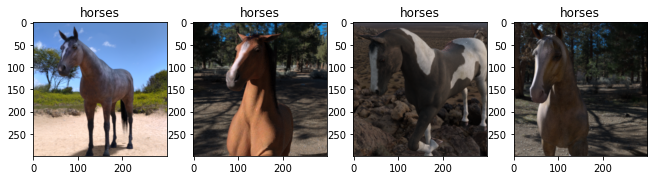

In [79]:
show_images_from_directionry_randomly(horses_train_filepaths, 4)

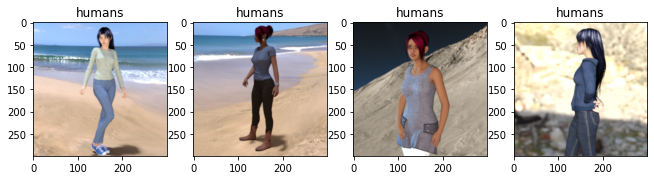

In [80]:
show_images_from_directionry_randomly(humans_train_filepaths, 4)

## Validation set

In [81]:
horses_validation_filepaths_pattern = os.path.join(validation_dir, 'horses', '*') 
horses_validation_filepaths = glob.glob(horses_validation_filepaths_pattern)

horses_validation_filepaths_pattern = os.path.join(validation_dir, 'humans', '*')
humans_validation_filepaths = glob.glob(horses_validation_filepaths_pattern)

print('In the validation set:')
print('Number horse images: ', len(horses_validation_filepaths))
print('Number human images: ', len(humans_validation_filepaths))

In the validation set:
Number horse images:  128
Number human images:  128


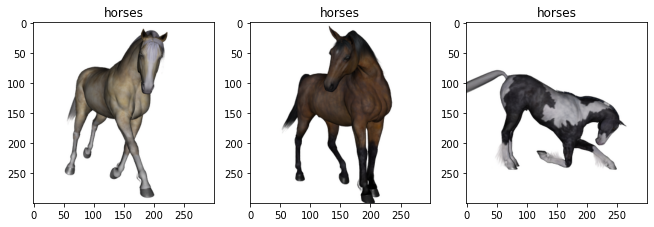

In [82]:
show_images_from_directionry_randomly(horses_validation_filepaths)

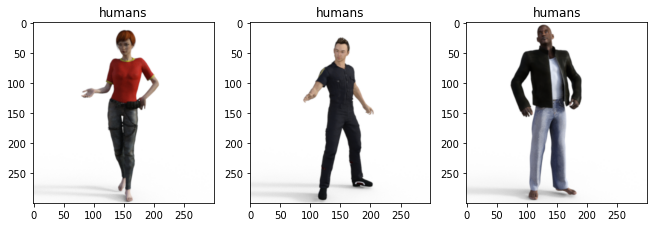

In [83]:
show_images_from_directionry_randomly(humans_validation_filepaths)

# Creat the dataset for training

## Processing with Augmentation

In [84]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
                                                                    
validation_datagen = ImageDataGenerator(rescale=1/255)



## Dataset (Generator)

In [85]:
# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=128,
        class_mode='binary')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,  # This is the source directory for validation images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


# Model

In [104]:
model = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    #tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 74, 74, 16)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 37, 37, 16)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 35, 35, 64)        9280      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 15, 15, 64)       

# Training and history

In [108]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=50,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8)

Epoch 1/50
8/8 [==============================] - 10s 1s/step - loss: 0.4474 - accuracy: 0.7910 - val_loss: 0.9193 - val_accuracy: 0.5625
Epoch 2/50
8/8 [==============================] - 9s 1s/step - loss: 0.4641 - accuracy: 0.7786 - val_loss: 0.7836 - val_accuracy: 0.5664
Epoch 3/50
8/8 [==============================] - 9s 1s/step - loss: 0.4195 - accuracy: 0.8020 - val_loss: 2.1465 - val_accuracy: 0.5000
Epoch 4/50
8/8 [==============================] - 9s 1s/step - loss: 0.4992 - accuracy: 0.7753 - val_loss: 1.0136 - val_accuracy: 0.6133
Epoch 5/50
8/8 [==============================] - 10s 1s/step - loss: 0.4281 - accuracy: 0.7949 - val_loss: 0.3773 - val_accuracy: 0.8047
Epoch 6/50
8/8 [==============================] - 10s 1s/step - loss: 0.3932 - accuracy: 0.8271 - val_loss: 0.2944 - val_accuracy: 0.9023
Epoch 7/50
8/8 [==============================] - 9s 1s/step - loss: 0.3763 - accuracy: 0.8331 - val_loss: 0.5517 - val_accuracy: 0.7812
Epoch 8/50
8/8 [======================

In [ ]:
#pd.DataFrame(history.history()).plot()

In [111]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

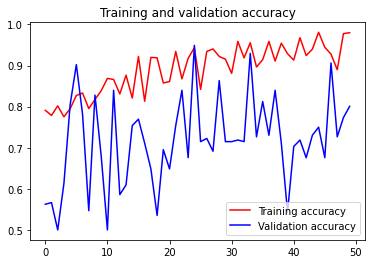

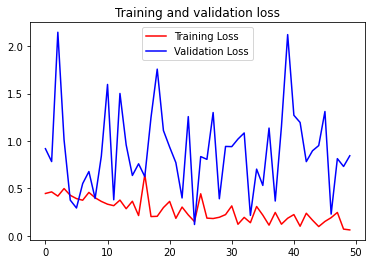

In [112]:
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()